# Advanced Lane Lines

---

## Module Imports

---

In [1]:
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import mean_squared_error

## Camera Calibration

---

In [2]:
def calibrate_camera():
    
    obj_point_container = []
    img_point_container = []
    
    # The number of corners
    nx = 9
    ny = 6

    # Import images 
    images = glob.glob('camera_cal/calibration*.jpg')

    # Preparing the object's corners
    obj_point = np.zeros((ny*nx,3), np.float32)
    obj_point[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    for index, file_name in enumerate(images):
        image = cv2.imread(file_name)
        # Convert to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray_image, (nx, ny), None)
        # If found, draw corners
        if ret == True:
            # draw and display the corners
            cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
            obj_point_container.append(obj_point)
            img_point_container.append(corners)
            
    return (obj_point_container, img_point_container)



## Undistort Camera

---

In [3]:
def undistort_camera(img_points, obj_points, img):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_size,None,None)
    return cv2.undistort(img, mtx, dist, None, mtx)

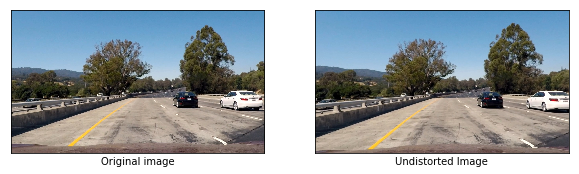

In [4]:
obj_point, img_point = calibrate_camera()
img = mpimg.imread('test_images/test1.jpg')
undistorted_img = undistort_camera(img_point, obj_point, img)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.xlabel('Original image')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(1, 2, 2)
plt.imshow(undistorted_img)
plt.xlabel('Undistorted Image')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

## Perspective Transform

---

In [5]:
def transform_perspective (img):
    src_coords = np.float32([
        [490,482],
        [810,482],
        [1250,720],
        [40,720]
    ])
    
    dst_coords = np.float32([
        [0,0],
        [1280,0],
        [1250,720],
        [40,720]
    ])
    
    M = cv2.getPerspectiveTransform(src_coords, dst_coords)
    
    return cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_NEAREST)

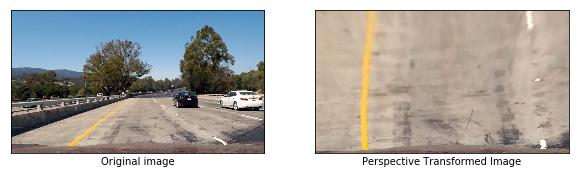

In [6]:
img = mpimg.imread('test_images/test1.jpg')
undistorted_img = undistort_camera(img_point, obj_point, img)
perspective_transform_img = transform_perspective(undistorted_img)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.xlabel('Original image')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(1, 2, 2)
plt.imshow(perspective_transform_img)
plt.xlabel('Perspective Transformed Image')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

## Binary Thresholds

--- 

In [7]:
def s_channel(img, threshold_min, threshold_max):
    s_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= threshold_min) & (s_channel <= threshold_max)] = 1
    return s_binary

def l_channel(img, threshold_min, threshold_max):
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= threshold_min) & (l_channel <= threshold_max)] = 1
    return l_binary

def combine_binary(s_binary, l_binary):
    binary = np.zeros_like(s_binary)
    binary[(l_binary == 1) | (s_binary == 1)] = 1
    return binary

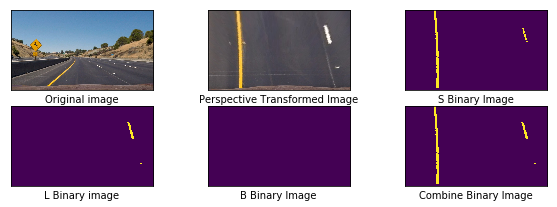

In [8]:
img = mpimg.imread('test_images/test2.jpg')
undistorted_img = undistort_camera(img_point, obj_point, img)
perspective_transform_img = transform_perspective(undistorted_img)

s_binary = s_channel(perspective_transform_img, 180, 255)
l_binary = l_channel(perspective_transform_img, 225, 255)
b_binary = b_channel(perspective_transform_img, 155, 200)
combine_binary = combine_binary(s_binary, l_binary, b_binary)

plt.figure(figsize=(10,5))
plt.subplot(2, 3, 1)
plt.imshow(img)
plt.xlabel('Original image')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(2, 3, 2)
plt.imshow(perspective_transform_img)
plt.xlabel('Perspective Transformed Image')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(2, 3, 3)
plt.imshow(undistorted_img)
plt.xlabel('Undistorted Image')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(2, 3, 3)
plt.imshow(s_binary)
plt.xlabel('S Binary Image')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(2, 3, 4)
plt.imshow(l_binary)
plt.xlabel('L Binary image')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(2, 3, 6)
plt.imshow(combine_binary)
plt.xlabel('Combine Binary Image')
plt.xticks([], [])
plt.yticks([], [])
plt.show()